# Домашнее задание к занятию "Многослойная нейронная сеть"

Задание

Постройте модель на основе полносвязных слоёв для классификации Fashion MNIST из библиотеки torchvision ( [datasets](https://pytorch.org/vision/stable/datasets.html)).
Получите качество на тестовой выборке не ниже 88%

Инструкция по выполнению задания:

* Скачайте тренировочную и тестовою часть датасета
* Постройте модель, выбрав стартовую архитектуру
* Обучите модель и сверьте качество на тестовой части с заданным порогом
* Изменяйте архитектуру модели пока качество на тестовой части не будет выше порога.
* Вариации архитектуры можно реализовать через изменение количества слоёв, количества нейронов в слоях и использование регуляризации. Можно использовать различные оптимизаторы.


### Импорт библиотек

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import numpy as np
import torchvision as tv
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import time


### Загрузка данных

In [ ]:
BATCH_SIZE=128

In [ ]:
train_dataset = tv.datasets.FashionMNIST('.', train=True, transform=tv.transforms.ToTensor(), download=True)
test_dataset = tv.datasets.FashionMNIST('.', train=False, transform=tv.transforms.ToTensor(), download=True)
train = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

100%|██████████| 26421880/26421880 [00:02<00:00, 12814335.43it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 212503.70it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 4015977.64it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5048463.17it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### отрисовка классов

In [ ]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat",
                 5: "Sandal",
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [ ]:
a = output_label(0)
a

'T-shirt/Top'

In [ ]:
a = next(iter(train))
a[0].size()

torch.Size([128, 1, 28, 28])

In [ ]:
len(train_dataset)

60000

9


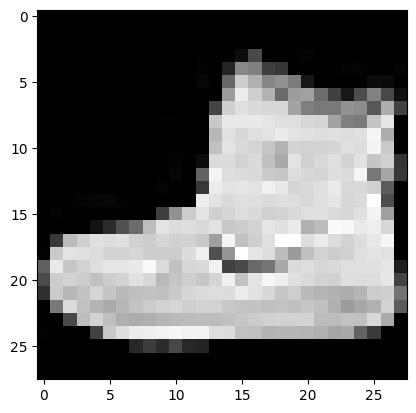

In [ ]:
image, label = next(iter(train_dataset))
plt.imshow(image.squeeze(), cmap="gray")
print(label)

In [ ]:
demo_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])


labels:  Ankle Boot, T-shirt/Top, T-shirt/Top, Dress, T-shirt/Top, Pullover, Sneaker, Pullover, Sandal, Sandal, 

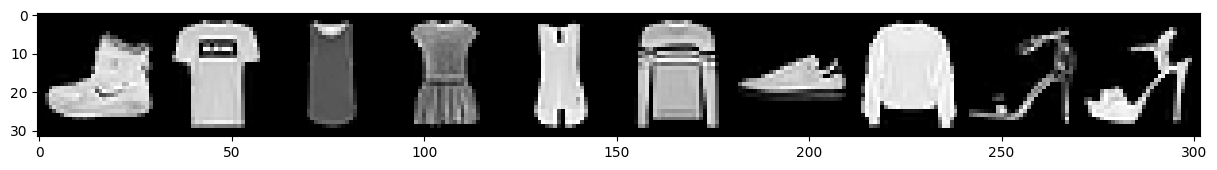

In [ ]:
grid = tv.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

### Класс для создания стартовой сети

In [ ]:
class FashionMnist(nn.Module):

    def __init__(self):
        super(FashionMnist, self).__init__()
        self.flt = nn.Flatten()
        self.fn1 = nn.Linear(784, 256)
        self.fn2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.flt(x)
        x = self.fn1(x)
        x = F.relu(self.fn2(x))

        return x



model = FashionMnist()
model.to(device)

FashionMnist(
  (flt): Flatten(start_dim=1, end_dim=-1)
  (fn1): Linear(in_features=784, out_features=256, bias=True)
  (fn2): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
# инициализация функции потерь и оптимизатора
loss = torch.nn.CrossEntropyLoss()
trainer = torch.optim.SGD(model.parameters(), lr=.01)
num_epochs = 10

### Функция обучения

In [ ]:
def train_model():
    for ep in range(num_epochs):
        train_iters, train_passed  = 0, 0
        train_loss, train_acc = 0., 0.
        start=time.time()

        model.train()
        for X, y in train:
            X = X.to(device)
            y = y.to(device)
            trainer.zero_grad()
            y_pred = model(X)
            l = loss(y_pred, y)
            l.backward()
            trainer.step()
            train_loss += l.item()
            train_acc += (y_pred.argmax(dim=1) == y).sum().item()
            train_iters += 1
            train_passed += len(X)

        test_iters, test_passed  = 0, 0
        test_loss, test_acc = 0., 0.
        model.eval()
        for X, y in test:
            X = X.to(device)
            y = y.to(device)
            y_pred = model(X)
            l = loss(y_pred, y)
            test_loss += l.item()
            test_acc += (y_pred.argmax(dim=1) == y).sum().item()
            test_iters += 1
            test_passed += len(X)

        print("ep: {}, taked: {:.3f}, train_loss: {}, train_acc: {}%, test_loss: {}, test_acc: {}%,".format(
            ep, time.time() - start, train_loss / train_iters, round(((train_acc/ train_passed)*100), 2),
            test_loss / test_iters, round(((test_acc/ test_passed)*100), 2))
        )

In [ ]:
train_model()

ep: 0, taked: 10.566, train_loss: 1.6855292935361232, train_acc: 47.61%, test_loss: 1.4038858640043042, test_acc: 52.97%,
ep: 1, taked: 7.028, train_loss: 1.3263173347343005, train_acc: 56.38%, test_loss: 1.2745217960092086, test_acc: 57.46%,
ep: 2, taked: 7.706, train_loss: 1.2393294350424808, train_acc: 59.16%, test_loss: 1.2158931010886083, test_acc: 59.42%,
ep: 3, taked: 7.788, train_loss: 1.19261756571117, train_acc: 60.39%, test_loss: 1.181278559226024, test_acc: 60.22%,
ep: 4, taked: 7.006, train_loss: 1.16279381259418, train_acc: 61.04%, test_loss: 1.1583273395707336, test_acc: 60.77%,
ep: 5, taked: 7.680, train_loss: 1.1055218027090468, train_acc: 61.69%, test_loss: 1.030923540079141, test_acc: 62.14%,
ep: 6, taked: 7.410, train_loss: 0.997698398414197, train_acc: 63.36%, test_loss: 0.9968861462194708, test_acc: 63.18%,
ep: 7, taked: 7.247, train_loss: 0.9707000972365519, train_acc: 64.39%, test_loss: 0.9771620140799994, test_acc: 63.84%,
ep: 8, taked: 7.898, train_loss: 0.952

### Подбор параметров сети для улучшения показателей обучения

#### изменение оптимизатора

In [ ]:
loss = torch.nn.CrossEntropyLoss()
trainer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99))

num_epochs = 10

In [ ]:
train_model()

ep: 0, taked: 7.273, train_loss: 0.5295253286737878, train_acc: 81.57%, test_loss: 0.5390367673922188, test_acc: 81.2%,
ep: 1, taked: 7.949, train_loss: 0.4454728241032883, train_acc: 84.39%, test_loss: 0.477006268274935, test_acc: 83.39%,
ep: 2, taked: 7.572, train_loss: 0.4292883011323811, train_acc: 84.97%, test_loss: 0.466237548408629, test_acc: 83.92%,
ep: 3, taked: 7.483, train_loss: 0.419329587171581, train_acc: 85.36%, test_loss: 0.46327964829493173, test_acc: 83.97%,
ep: 4, taked: 7.907, train_loss: 0.41177430186571595, train_acc: 85.58%, test_loss: 0.45914543542680863, test_acc: 83.97%,
ep: 5, taked: 7.376, train_loss: 0.40603796886736904, train_acc: 85.75%, test_loss: 0.45712681699402724, test_acc: 83.94%,
ep: 6, taked: 7.926, train_loss: 0.4013789278040054, train_acc: 85.91%, test_loss: 0.45581646508808377, test_acc: 84.1%,
ep: 7, taked: 8.089, train_loss: 0.3977846408894321, train_acc: 86.04%, test_loss: 0.4558759663678423, test_acc: 84.16%,
ep: 8, taked: 7.317, train_loss

In [ ]:
trainer = torch.optim.RMSprop(model.parameters(), lr=0.01)

In [ ]:
train_model()

ep: 0, taked: 10.934, train_loss: 7.971532508826205, train_acc: 16.67%, test_loss: 2.3024603203882146, test_acc: 10.01%,
ep: 1, taked: 10.699, train_loss: 4.842534008310802, train_acc: 10.13%, test_loss: 2.3025853633880615, test_acc: 10.0%,
ep: 2, taked: 10.644, train_loss: 2.3025853633880615, train_acc: 10.0%, test_loss: 2.3025853633880615, test_acc: 10.0%,
ep: 3, taked: 10.727, train_loss: 2.3025853633880615, train_acc: 10.0%, test_loss: 2.3025853633880615, test_acc: 10.0%,
ep: 4, taked: 11.725, train_loss: 2.3025853633880615, train_acc: 10.0%, test_loss: 2.3025853633880615, test_acc: 10.0%,
ep: 5, taked: 10.606, train_loss: 2.3025853633880615, train_acc: 10.0%, test_loss: 2.3025853633880615, test_acc: 10.0%,
ep: 6, taked: 9.887, train_loss: 2.3025853633880615, train_acc: 10.0%, test_loss: 2.3025853633880615, test_acc: 10.0%,
ep: 7, taked: 10.812, train_loss: 2.3025853633880615, train_acc: 10.0%, test_loss: 2.3025853633880615, test_acc: 10.0%,
ep: 8, taked: 10.785, train_loss: 2.3025

#### добавление Dropout

In [ ]:
# классс с добавлением Dropout слоев
class FashionMnist(nn.Module):

    def __init__(self):
        super(FashionMnist, self).__init__()
        self.flt = nn.Flatten()
        self.fn1 = nn.Linear(784, 2560)
        self.act1 = nn.ReLU()
        self.dropout1 =  nn.Dropout(p=0.5, inplace=False)
        self.fn2 = nn.Linear(2560, 1280)
        self.act2 = nn.ReLU()
        self.dropout2 =  nn.Dropout(p=0.5, inplace=False)
        self.fn3 = nn.Linear(1280, 640)
        self.act3 = nn.ReLU()
        self.dropout3 =  nn.Dropout(p=0.5, inplace=False)
        self.fn4 = nn.Linear(640, 10)

    def forward(self, x):
        x = self.flt(x)
        x = self.act1(self.fn1(x))
        x = self.dropout1(x)
        x = self.act2(self.fn2(x))
        x = self.dropout2(x)
        x = self.act2(self.fn3(x))
        x = self.dropout3(x)
        x = self.fn4(x)

        return x

model = FashionMnist()
model.to(device)

FashionMnist(
  (flt): Flatten(start_dim=1, end_dim=-1)
  (fn1): Linear(in_features=784, out_features=2560, bias=True)
  (act1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fn2): Linear(in_features=2560, out_features=1280, bias=True)
  (act2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fn3): Linear(in_features=1280, out_features=640, bias=True)
  (act3): ReLU()
  (dropout3): Dropout(p=0.5, inplace=False)
  (fn5): Linear(in_features=640, out_features=10, bias=True)
)

In [ ]:
trainer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99))
num_epochs = 20
train_model()

ep: 0, taked: 9.218, train_loss: 0.3684044415190784, train_acc: 87.11%, test_loss: 0.36052990808517116, test_acc: 87.55%,
ep: 1, taked: 9.158, train_loss: 0.3537338802110412, train_acc: 87.42%, test_loss: 0.36126564065866834, test_acc: 87.73%,
ep: 2, taked: 9.216, train_loss: 0.3550036941319386, train_acc: 87.51%, test_loss: 0.3640012067707279, test_acc: 87.73%,
ep: 3, taked: 8.574, train_loss: 0.34476634462886274, train_acc: 87.83%, test_loss: 0.355923496658289, test_acc: 87.98%,
ep: 4, taked: 9.127, train_loss: 0.34492552493299755, train_acc: 87.79%, test_loss: 0.3546910759391664, test_acc: 88.02%,
ep: 5, taked: 9.108, train_loss: 0.3402095564456383, train_acc: 87.95%, test_loss: 0.3528236827895611, test_acc: 87.46%,
ep: 6, taked: 9.229, train_loss: 0.34204176595724467, train_acc: 87.93%, test_loss: 0.3619977688487572, test_acc: 87.73%,
ep: 7, taked: 9.149, train_loss: 0.3386823212477698, train_acc: 88.13%, test_loss: 0.3572012104942829, test_acc: 87.94%,
ep: 8, taked: 9.090, train_l

#### добавление BatchNorm

In [ ]:
# классс с добавлением BatchNorm слоев
class FashionMnist(nn.Module):

    def __init__(self):
        super(FashionMnist, self).__init__()
        self.flt = nn.Flatten()
        self.fn1 = nn.Linear(784, 512)
        self.act1 = nn.ReLU()
        self.bn1 =  nn.BatchNorm1d(512)
        self.fn2 = nn.Linear(512, 256)
        self.act2 = nn.ReLU()
        self.bn2 =  nn.BatchNorm1d(256)
        self.fn3 = nn.Linear(256, 128)
        self.act3 = nn.ReLU()
        self.bn3 =  nn.BatchNorm1d(128)
        self.fn4 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flt(x)
        x = self.act1(self.fn1(x))
        x = self.bn1(x)
        x = self.act2(self.fn2(x))
        x = self.bn2(x)
        x = self.act2(self.fn3(x))
        x = self.bn3(x)
        x = self.fn4(x)

        return x

model = FashionMnist()
model.to(device)

FashionMnist(
  (flt): Flatten(start_dim=1, end_dim=-1)
  (fn1): Linear(in_features=784, out_features=512, bias=True)
  (act1): ReLU()
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fn2): Linear(in_features=512, out_features=256, bias=True)
  (act2): ReLU()
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fn3): Linear(in_features=256, out_features=128, bias=True)
  (act3): ReLU()
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fn4): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
train_model()

ep: 0, taked: 7.941, train_loss: 2.378104294795217, train_acc: 13.56%, test_loss: 2.38375282891189, test_acc: 13.92%,
ep: 1, taked: 7.482, train_loss: 2.378104294795217, train_acc: 13.56%, test_loss: 2.38375282891189, test_acc: 13.92%,
ep: 2, taked: 7.656, train_loss: 2.378104294795217, train_acc: 13.56%, test_loss: 2.38375282891189, test_acc: 13.92%,
ep: 3, taked: 7.850, train_loss: 2.378104294795217, train_acc: 13.56%, test_loss: 2.38375282891189, test_acc: 13.92%,
ep: 4, taked: 7.261, train_loss: 2.378104294795217, train_acc: 13.56%, test_loss: 2.38375282891189, test_acc: 13.92%,
ep: 5, taked: 7.900, train_loss: 2.378104294795217, train_acc: 13.56%, test_loss: 2.38375282891189, test_acc: 13.92%,
ep: 6, taked: 7.920, train_loss: 2.378104294795217, train_acc: 13.56%, test_loss: 2.38375282891189, test_acc: 13.92%,
ep: 7, taked: 7.248, train_loss: 2.378104294795217, train_acc: 13.56%, test_loss: 2.38375282891189, test_acc: 13.92%,
ep: 8, taked: 7.943, train_loss: 2.378104294795217, trai

Вывод: лучший результат модель показала с оптимизатором Adam и со слоями Dropout